<a href="https://colab.research.google.com/github/Arijit-datascience/EVA6-BatchNormalization-Regularization/blob/main/MNIST_Digit_Recognition_Batch_Normalization_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# Reading MNIST data

In [54]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [55]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True,transform=test_transforms)

In [29]:
n_train = len(train_data)
n_test = len(test_data)

print('Number of training samples: {0}'.format(n_train))
print('Number of test samples: {0}'.format(n_test))

Number of training samples: 60000
Number of test samples: 10000


# Model Architecture

In [129]:
DROPOUT_VALUE = 0.04

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )
        
        # CONVOLUTION BLOCK 1
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )

        # TRANSITION BLOCK 1
        self.trans = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.MaxPool2d(2, 2)
        )
        
        # CONVOLUTION BLOCK 2
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(DROPOUT_VALUE)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(DROPOUT_VALUE)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
        )

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) 

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gap(x)        
        x = self.conv6(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Summary

In [130]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 16, 24, 24]           1,152
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
      BatchNorm2d-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [-1, 1

# Model

In [131]:
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (trans): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.04, inplace=False

# Data Loading ...

In [116]:
torch.manual_seed(1)
batch_size = 64

cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(1)

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, **kwargs)

# Train Loop

In [118]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    print(f'Train set: Average loss: {loss.item():.4f}, Accuracy: {100. * correct/len(train_loader.dataset):.2f}')
    train_loss = epoch_loss / len(train_loader)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss, train_acc

# Test Loop

In [119]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 100.*correct/len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.3f}, Accuracy: {100. * correct/len(test_loader.dataset):.2f}')
    return test_loss, test_acc

# Defining optimizer and learning rate scheduler

In [123]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.8)
scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=15,steps_per_epoch=len(train_loader))

# Running the model

In [124]:
train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

for epoch in range(1, 16):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss, train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_acc_values.append(train_acc)
    test_acc_values.append(test_acc)    


Epoch 1 : 
Train set: Average loss: 0.2368, Accuracy: 75.99

Test set: Average loss: 0.147, Accuracy: 96.92

Epoch 2 : 
Train set: Average loss: 0.0842, Accuracy: 96.97

Test set: Average loss: 0.047, Accuracy: 98.67

Epoch 3 : 
Train set: Average loss: 0.2310, Accuracy: 97.84

Test set: Average loss: 0.057, Accuracy: 98.29

Epoch 4 : 
Train set: Average loss: 0.0416, Accuracy: 98.23

Test set: Average loss: 0.031, Accuracy: 98.98

Epoch 5 : 
Train set: Average loss: 0.1944, Accuracy: 98.49

Test set: Average loss: 0.026, Accuracy: 99.21

Epoch 6 : 
Train set: Average loss: 0.0406, Accuracy: 98.69

Test set: Average loss: 0.026, Accuracy: 99.21

Epoch 7 : 
Train set: Average loss: 0.1090, Accuracy: 98.80

Test set: Average loss: 0.028, Accuracy: 99.09

Epoch 8 : 
Train set: Average loss: 0.0040, Accuracy: 98.84

Test set: Average loss: 0.023, Accuracy: 99.30

Epoch 9 : 
Train set: Average loss: 0.0190, Accuracy: 99.00

Test set: Average loss: 0.020, Accuracy: 99.35

Epoch 10 : 
Train 

# Plotting the train and test loss across each epoch

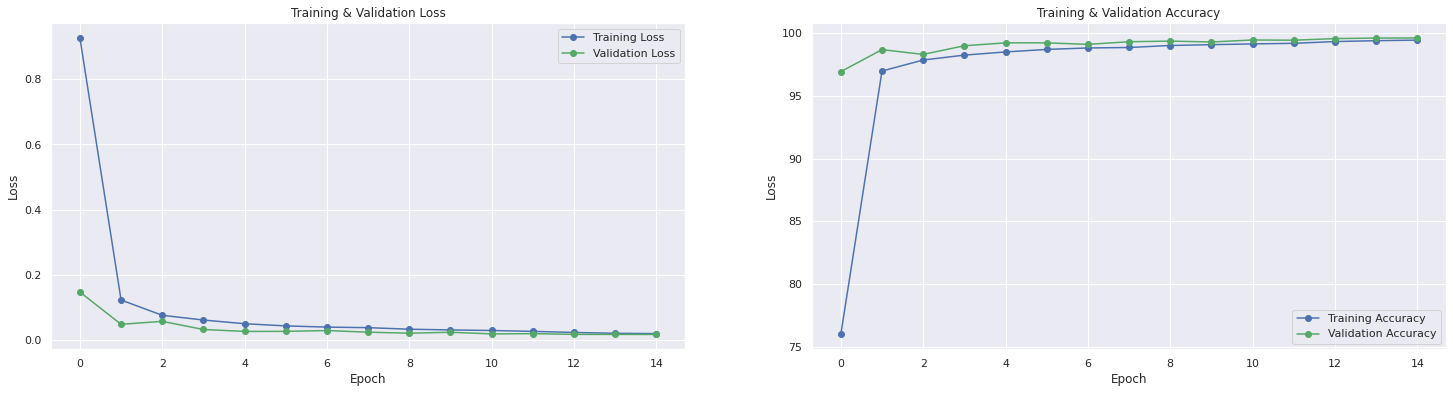

In [125]:
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='whitegrid')

# Increase the plot size and font size.
sns.set(font_scale=1)
plt.rcParams["figure.figsize"] = (25,6)

# Plot the learning curve.
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(np.array(train_loss_values), 'b-o', label="Training Loss")
ax1.plot(np.array(test_loss_values), 'g-o', label="Validation Loss")

# Label the plot.
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(np.array(train_acc_values), 'b-o', label="Training Accuracy")
ax2.plot(np.array(test_acc_values), 'g-o', label="Validation Accuracy")

# Label the plot.
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()

# Average Test Loss

In [126]:
print(f'Average test loss: {test_loss:.3f}')

Average test loss: 0.016
